In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = (8,6)
%matplotlib inline

In [2]:
def newline(p1, p2, color=None): # line drawing function
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], color=color)
    ax.add_line(l)
    return l

In [3]:
def add_bias_feature(a):
    a_extended = np.zeros((a.shape[0],a.shape[1]+1))
    a_extended[:,:-1] = a
    a_extended[:,-1] = int(1)  
    return a_extended

class CustomSVM(object):

    __class__ = "CustomSVM"

    def __init__(self, etha=0.01, alpha=0.1, epochs=200):
        self._epochs = epochs
        self._etha = etha
        self._alpha = alpha
        self._w = None
        self.history_w = []
        self.train_errors = None
        self.val_errors = None
        self.train_loss = None
        self.val_loss = None

    def fit(self, X_train, Y_train, X_val, Y_val, verbose=False): #arrays: X; Y =-1,1

        if len(set(Y_train)) != 2 or len(set(Y_val)) != 2:
            raise ValueError("Number of classes in Y is not equal 2!")

        X_train = add_bias_feature(X_train)
        X_val = add_bias_feature(X_val)
        self._w = np.random.normal(loc=0, scale=0.05, size=X_train.shape[1])
        self.history_w.append(self._w)
        train_errors = []
        val_errors = []
        train_loss_epoch = []
        val_loss_epoch = []

        for epoch in range(self._epochs): 
            tr_err = 0
            val_err = 0
            tr_loss = 0
            val_loss = 0
            for i,x in enumerate(X_train):
                margin = Y_train[i]*np.dot(self._w,X_train[i])
                if margin >= 1: # classify correctly
                    self._w = self._w - self._etha*self._alpha*self._w/self._epochs
                    tr_loss += self.soft_margin_loss(X_train[i],Y_train[i])
                else: # classify incorrectly or fall into the separation strip for 0 <m <1
                    self._w = self._w +\
                    self._etha*(Y_train[i]*X_train[i] - self._alpha*self._w/self._epochs)
                    tr_err += 1
                    tr_loss += self.soft_margin_loss(X_train[i],Y_train[i])
                self.history_w.append(self._w)
            for i,x in enumerate(X_val):
                val_loss += self.soft_margin_loss(X_val[i], Y_val[i])
                val_err += (Y_val[i]*np.dot(self._w,X_val[i])<1).astype(int)
            if verbose:
                print('epoch {}. Errors={}. Mean Hinge_loss={}'\
                      .format(epoch,err,loss))
            train_errors.append(tr_err)
            val_errors.append(val_err)
            train_loss_epoch.append(tr_loss)
            val_loss_epoch.append(val_loss)
        self.history_w = np.array(self.history_w)    
        self.train_errors = np.array(train_errors)
        self.val_errors = np.array(val_errors)
        self.train_loss = np.array(train_loss_epoch)
        self.val_loss = np.array(val_loss_epoch)                    

    def predict(self, X:np.array) -> np.array:
        y_pred = []
        X_extended = add_bias_feature(X)
        for i in range(len(X_extended)):
            y_pred.append(np.sign(np.dot(self._w,X_extended[i])))
        return np.array(y_pred)         

    def hinge_loss(self, x, y):
        return max(0,1 - y*np.dot(x, self._w))

    def soft_margin_loss(self, x, y):
        return self.hinge_loss(x,y)+self._alpha*np.dot(self._w, self._w)

# Training data points are linearly separable

In [4]:
data_train = pd.read_csv("train_data_separable.csv")
data_train.columns = ["x1", "x2", "label"]
data_test = pd.read_csv("train_data_separable.csv")
data_test.columns = ["x1", "x2", "label"]
X_train, X_test, Y_train, Y_test = data_train[["x1", "x2"]], data_test[["x1", "x2"]], data_train["label"], data_test["label"]

[36 26 25 24 23 22 21 19 16 15 15 15 14 13 13 12 11 11 11 11 11 10 11 10
 10  9  9  9  8  9  8  9  8  8  7  7  8  7  8  7  7  8  7  7  8  7  7  8
  7  7  6  6  6  7  6  6  6  6  6  6  5  5  6  5  5  5  6  5  5  5  6  5
  5  6  4  5  5  4  3  4  4  4  4  4  4  3  4  3  3  3  4  3  3  3  4  3
  3  4  4  3  4  3  3  3  4  4  4  4  3  4  3  3  4  4  3  4  3  3  3  4
  4  4  4  3  4  3  3  4  4  3  4  4  4  4  3  4  3  3  4  4  3  4  4  4
  3  3  3  4  4  3]
[ 0.10082381  0.91755437 -2.1922835 ]


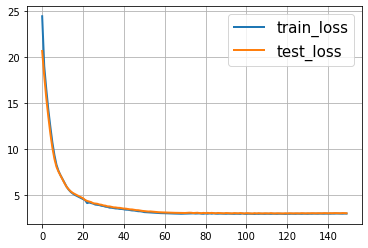

In [5]:
# initialization and training block
svm = CustomSVM(etha=0.005, alpha=0.006, epochs=150)
svm.fit(X_train, Y_train, X_test, Y_test)

print(svm.train_errors) # numbers of error in each epoch
print(svm._w) # w0*x_i[0]+w1*x_i[1]+w2=0

plt.plot(svm.train_loss, linewidth=2, label='train_loss')
plt.plot(svm.val_loss, linewidth=2, label='test_loss')
plt.grid()
plt.legend(prop={'size': 15})
plt.show()

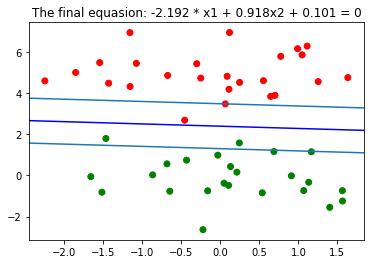

In [6]:
d = {-1:'green', 1:'red'}
plt.scatter(X_train["x1"], X_train["x2"], c=[d[y] for y in Y_train])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue')  # in w0*x_i[0]+w1*x_i[1]+w2*1=0 substitute 
                                                                    # x_i[0]=0, x_i[1]=0
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) # w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) # w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.title('The final equasion: {:.3f} * x1 + {:.3f}x2 + {:.3f} = 0'.format(svm._w[2], svm._w[1], svm._w[0]))
plt.show()

# Test points are linearly separable

Number of errors for deferred sampling:  0


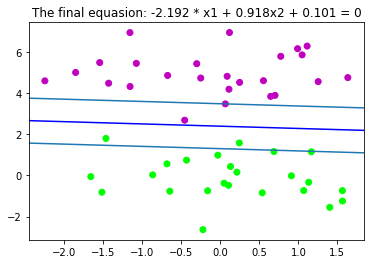

In [7]:
# predict after training
y_pred = svm.predict(X_test)
y_pred[y_pred != Y_test] = -100 # find and mark classification error
print('Number of errors for deferred sampling: ', (y_pred == -100).astype(int).sum())
d1 = {-1:'lime', 1:'m', -100: 'black'} # black = classification error
plt.scatter(X_test["x1"], X_test["x2"], c=[d1[y] for y in y_pred])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue')
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.title('The final equasion: {:.3f} * x1 + {:.3f}x2 + {:.3f} = 0'.format(svm._w[2], svm._w[1], svm._w[0]))
plt.show()

In [8]:
yhat_train = svm.predict(X_train)
yhat_test = svm.predict(X_test)
train_error1 = (np.sum(Y_train != yhat_train) / len(X_train)) * 100
test_error1 = (np.sum(Y_test != yhat_test) / len(X_test)) * 100

# Training data points are not linearly separable

In [9]:
data_train = pd.read_csv("train_data_nonseparable.csv")
data_train.columns = ["x1", "x2", "label"]
data_test = pd.read_csv("train_data_separable.csv")
data_test.columns = ["x1", "x2", "label"]
X_train, X_test, Y_train, Y_test = data_train[["x1", "x2"]], data_test[["x1", "x2"]], data_train["label"], data_test["label"]

[39 28 24 21 19 18 16 16 16 16 14 14 13 13 11 14 13 12 11 11 11 10 10 11
 10 10 11 12 11 10 10 10 10 10 11 11 10 10 10 10 11 11 10 10 10 10 10 12
 11 11 10 10 10 11 10 11 10 10 10 11 10 10 11 10 10 10 11 10 11 10 10 10
 11 10 11 10 10 10 10 11 10 11 10 10 10 10 11 11 10 10 10 10 11 11 11 11
 10 10 11 10 10 11 10 10 11 10 10 11 10 10 10 11 10 10 11 10 10 10 11 10
 11 10 10 10 11 10 11 10 10 10 10 11 10 11 10 10 10 10 11 11 10 10 10 10
 11 11 11 11 10 10]
[-0.17723678  1.81027013 -1.60019413]


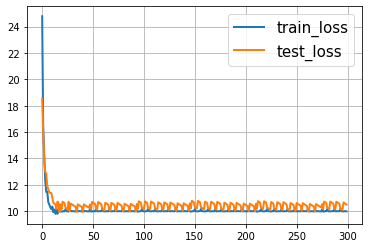

In [10]:
# initialization and training block
svm = CustomSVM(etha=0.03, alpha=0.0001, epochs=300)
svm.fit(X_train, Y_train, X_test, Y_test)

print(svm.train_errors[:150]) # numbers of error in each epoch
print(svm._w) # w0*x_i[0]+w1*x_i[1]+w2=0

plt.plot(svm.train_loss, linewidth=2, label='train_loss')
plt.plot(svm.val_loss, linewidth=2, label='test_loss')
plt.grid()
plt.legend(prop={'size': 15})
plt.show()

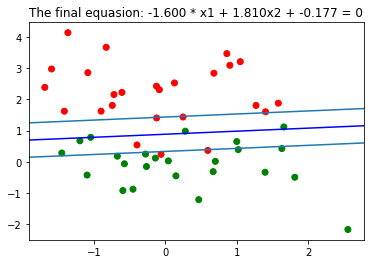

In [11]:
d = {-1:'green', 1:'red'}
plt.scatter(X_train["x1"], X_train["x2"], c=[d[y] for y in Y_train])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue')  # in w0*x_i[0]+w1*x_i[1]+w2*1=0 substitute
                                                                    # x_i[0]=0, x_i[1]=0
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) # w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) # w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.title('The final equasion: {:.3f} * x1 + {:.3f}x2 + {:.3f} = 0'.format(svm._w[2], svm._w[1], svm._w[0]))
plt.show()

# Test points are not linearly separable

Number of errors for deferred sampling:  5


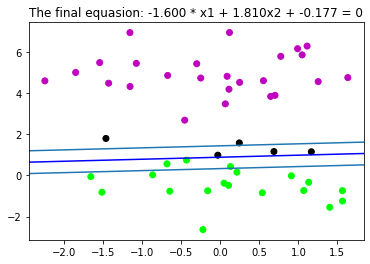

In [12]:
# predict after training
y_pred = svm.predict(X_test)
y_pred[y_pred != Y_test] = -100 # find and mark classification error
print('Number of errors for deferred sampling: ', (y_pred == -100).astype(int).sum())
d1 = {-1:'lime', 1:'m', -100: 'black'} # black = classification error
plt.scatter(X_test["x1"], X_test["x2"], c=[d1[y] for y in y_pred])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue')
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.title('The final equasion: {:.3f} * x1 + {:.3f}x2 + {:.3f} = 0'.format(svm._w[2], svm._w[1], svm._w[0]))
plt.show()

In [13]:
yhat_train = svm.predict(X_train)
yhat_test = svm.predict(X_test)
train_error2 = (np.sum(Y_train != yhat_train) / len(X_train)) * 100
test_error2 = (np.sum(Y_test != yhat_test) / len(X_test)) * 100

In [14]:
print('Percent of error for perceptron trained on linearly separable data:')
print('Train error: {}%'.format(train_error1))
print('Test error: {}%'.format(test_error1))
print('Percent of error for perceptron trained on non-linearly separable data:')
print('Train error: {}%'.format(train_error2))
print('Test error: {}%'.format(test_error2))

Percent of error for perceptron trained on linearly separable data:
Train error: 0.0%
Test error: 0.0%
Percent of error for perceptron trained on non-linearly separable data:
Train error: 12.244897959183673%
Test error: 10.204081632653061%


1.	whether the training data points are linearly separable,

    The training data points are linearly separable and not linearly separable
2.	whether the test points are linearly separable,

    The test points are linearly separable and not linearly separable
3.	your initial choice of the weights and constants, 

    np.random.normal(loc=0, scale=0.05, size=X_train.shape[1])
4.	the final solution equation of the line (decision boundary), 

    linearly separable: -2.181x1+0.930x2+0.102=0;
    not linearly separable: -1.595x1+1.821x2-0.167=0
5.	the total number of weight vector updates that your algorithm made, 

    150
6.	the final misclassification error, if any (expressed as a percentage), on the training data as well as on the test data,
    Percent of error for perceptron trained on linearly separable data:
    
    Train error: 0.0%
    
    Test error: 0.0%
    
    Percent of error for perceptron trained on non-linearly separable data:
    
    Train error: 12.244897959183673%
    
    Test error: 10.204081632653061%
    
7.	the margin width (in both separable and non-separable cases, separately), 
8.	whether the SVM solution is the same as or different from the PLA solution (i) in the linearly separable case, (ii) in the non-separable case,

    The SVM solution is the same as the PLA solution in the linearly separable case and different in the non-separable case.
9.	a brief comparison between the PLA and SVM solutions for the linearly non-separable case (e.g., number of mis-classified points).  

    In my opinion, PLA is the best method. 
